In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=4)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.1.72:34867 Dashboard: http://10.148.1.72:8787/status,Cluster Workers: 28 Cores: 28 Memory: 479.92 GB


### Load eulerian field average

In [5]:
eulerian_field = xr.open_dataset('/home1/datawork/zcaspar/diags/avgE.nc')

In [7]:
eulerian_field.u_tmean

<xarray.DataArray 'u_tmean' (y_rho: 145, x_rho: 52)>
array([[-9.349330e-05, -8.183898e-05, -6.563142e-05, ..., -1.443526e-04,
        -1.103099e-04, -9.545680e-05],
       [-3.160502e-04, -3.184435e-04, -3.135324e-04, ..., -2.993994e-04,
        -3.009731e-04, -3.139368e-04],
       [ 1.869998e-04,  2.014761e-04,  2.085459e-04, ...,  2.070478e-04,
         1.922140e-04,  1.860045e-04],
       ...,
       [ 2.810506e-04,  3.861854e-04,  4.094312e-04, ...,  5.902094e-04,
         4.435171e-04,  2.864588e-04],
       [ 5.206109e-04,  4.801026e-04,  4.293966e-04, ...,  2.943191e-04,
         4.259395e-04,  5.262307e-04],
       [ 4.757622e-04,  3.648827e-04,  4.071760e-04, ...,  3.358622e-04,
         5.450167e-04,  5.178528e-04]], dtype=float32)
Coordinates:
    f             (y_rho) float32 ...
  * y_rho         (y_rho) float32 0.0 20000.0 40000.0 ... 2860000.0 2880000.0
    f_rho         (y_rho) float32 ...
  * x_rho         (x_rho) float32 0.0 20000.0 40000.0 ... 1000000.0 1020000.0
    s_rho_slice0  float32 ...

In [8]:
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

### Drifters trajectories

In [9]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=True)
dr

         time      xgrid      ygrid  zgrid     depth       temp         u  \
id                                                                          
1   1514.4167  25.897255  174.72748   50.0  0.870458  24.579730 -0.000864   
1   1508.3056  26.356433  168.51951   50.0  0.763907  24.579722  0.059964   
1   1508.2986  26.348080  168.48829   50.0  0.764288  24.579721  0.054308   
1   1508.2917  26.340585  168.45690   50.0  0.764393  24.579721  0.048543   
1   1508.2847  26.333961  168.42548   50.0  0.764202  24.579721  0.042720   

           v      dudt          dvdt      pres           x          y  
id                                                                     
1   0.089855  0.000009 -9.453702e-06  9.414380  103.589020  698.90992  
1   0.203875  0.000010 -4.799399e-06  8.369084  105.425732  674.07804  
1   0.207708  0.000010 -3.143696e-06  8.372827  105.392320  673.95316  
1   0.209148  0.000010 -1.401524e-06  8.373855  105.362340  673.82760  
1   0.209600  0.000010  3.03

In [12]:
#test interpolation  on  drifter trajectories : 
import scipy.interpolate as interpolate
df = dr.df.loc[225].compute()

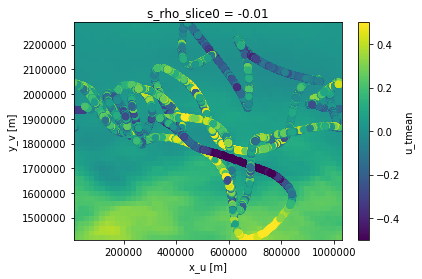

In [38]:
#
eulerian_field.u_tmean.sel(x_rho=slice(df.x.min()*1e3,df.x.max()*1e3),y_rho=slice(df.y.min()*1e3,df.y.max()*1e3)).plot(vmin=-0.5,vmax=0.5,zorder=-1)
plt.scatter(df.x*1e3,df.y*1e3,c=df.u,vmin=-0.5,vmax=0.5)

In [39]:
mean_zon = eulerian_field.mean('x_rho')

In [106]:
uE = mean_zon.u_tmean.sel(y_rho=slice((df.y.min()-100)*1e3,(df.y.max()+100)*1e3))

number of points in y direction in eulerian field :  54
number of points in y direction along drifter trajectory :  71735


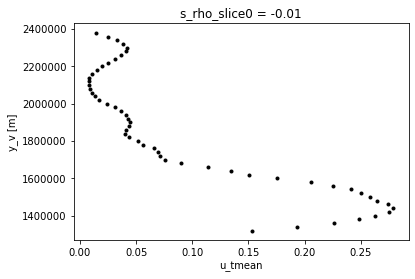

In [108]:
uE.plot.line('k.',y='y_rho')
print('number of points in y direction in eulerian field : ',uE.y_rho.size)
print('number of points in y direction along drifter trajectory : ',df.y.unique().size)

In [130]:
f = interpolate.interp1d(uE.y_rho,uE,kind='cubic')

In [107]:
print(uE.y_rho.max(),df.y.max()*1e3)

<xarray.DataArray 'y_rho' ()>
array(2380000., dtype=float32)
Coordinates:
    s_rho_slice0  float32 -0.01 2289850.52


In [131]:
uinterp = f(df.y*1e3)

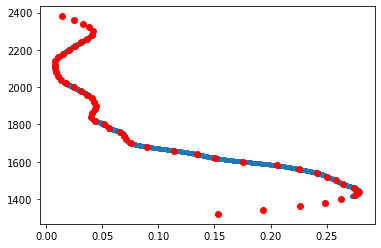

In [132]:
plt.plot(uinterp,df.y,'.')
plt.plot(uE,uE.y_rho*1e-3,'ro')

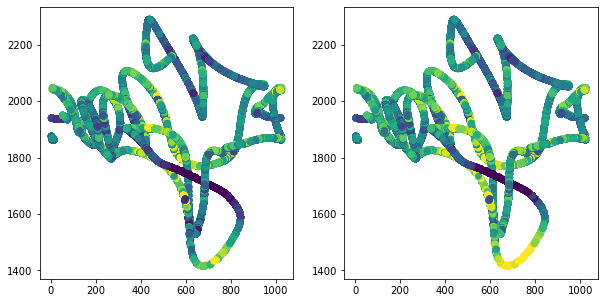

In [124]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df.x,df.y,c=(df.u-uinterp),vmin=-0.5,vmax=0.5)
ax[1].scatter(df.x,df.y,c=df.u,vmin=-0.5,vmax=0.5)

In [133]:
cluster.close()